In [2]:
# 基礎資料處理切分
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Deep Learning 相關
import torch
from torch import nn, optim, utils

# 系統互動
import time
import argparse

# 自訂部分
from model import ResNet50MothClassifierHMC

from dataset import ImageDatasetFromFileSpecial
from average_meter import AverageMeter

In [2]:
# 從命令列讀參數
parser = argparse.ArgumentParser()
parser.add_argument('--dataroot', default="./tesri_standard_256", type=str, help='path to dataset')
parser.add_argument('--batchSize', type=int, default=32, help='input batch size')
opt = parser.parse_args(args=[])

In [3]:
# 讀取資料
x_valid = np.load('./datasplit_cache/x_valid.npy', allow_pickle=True)
y_valid = np.load('./datasplit_cache/y_valid.npy', allow_pickle=True)
x_test = np.load('./datasplit_cache/x_test.npy', allow_pickle=True)
y_test = np.load('./datasplit_cache/y_test.npy', allow_pickle=True)

In [4]:
x_valid = [('./tesri_standard_256/%s' % f.split('/')[-1]) for f in x_valid]
x_test = [('./tesri_standard_256/%s' % f.split('/')[-1]) for f in x_test]

In [5]:
dataset_path = 'sp_meta.csv'
df = pd.read_csv(dataset_path, sep="\t")

# 移除未鑑定到種的資料
df = df[~df.Species.isna()].reset_index(drop=True)

genus = [s.split(' ')[0] for s in df.Species]
df['Genus'] = genus

# 造出物種清單，並產生每筆資料對應的物種 id, 視為 classification 用的 target y
species_list, species_id = np.unique(df.Species, return_inverse=True)
family_list, family_id = np.unique(df.Family, return_inverse=True)
genus_list, genus_id = np.unique(df.Genus, return_inverse=True)

test_set = ImageDatasetFromFileSpecial(x_test, '', y=y_test, aug=False, return_filename=True)
test_data_loader = utils.data.DataLoader(test_set, batch_size=opt.batchSize, shuffle=False)

valid_and_test_set = ImageDatasetFromFileSpecial(np.concatenate([x_valid, x_test]), '', y=np.concatenate([y_valid, y_test]), aug=False, return_filename=True)
valid_and_test_data_loader = utils.data.DataLoader(valid_and_test_set, batch_size=opt.batchSize, shuffle=False)

len(x_valid) + len(x_test)
np.concatenate([x_valid, x_test]).shape
np.unique(np.concatenate([x_valid, x_test])).shape

(19529,)

In [6]:
def load_model(model, pretrained):
    weights = torch.load(pretrained, map_location='cuda:0')
    pretrained_dict = weights['model'].state_dict()
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict) 
    model.load_state_dict(model_dict)

pretrained = "./resnet50_moth_classifier_hmc_20200806e158.pth"

# init model, 把模型搬進 GPU:0 的記憶體中
model = ResNet50MothClassifierHMC(num_of_species=len(species_list), num_of_genus=len(genus_list), num_of_families=len(family_list)).to('cuda:0')
load_model(model, pretrained)
model = model.eval()

# 設定分類器用的 cross entropy loss
cross_entropy = nn.CrossEntropyLoss()

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.3.0
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'model.ResNet50MothClassifierHMC' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.instancenorm.InstanceNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you 

In [52]:
files = []

preds_fid = []
preds_fname = []
preds_gid = []
preds_gname = []
preds_sid = []
preds_sname = []

labels_fid = []
labels_fname = []
labels_gid = []
labels_gname = []
labels_sid = []
labels_sname = []

probs_f = []
probs_g = []
probs_s = []

feats = []

match_s_topN_ = []

test_loss = AverageMeter()
test_loss_f = AverageMeter()
test_loss_g = AverageMeter()
test_loss_s = AverageMeter()

def pred_cuda_to_label(pred_):
    pred_softmax_numpy = nn.functional.softmax(pred_).data.clone().detach().cpu().numpy()
    pred = np.argmax(pred_softmax_numpy, axis=1)
    pred_prob = np.round(np.take_along_axis(pred_softmax_numpy, pred.reshape(-1,1), axis=1).reshape(-1) * 100 , 2)
    return pred, pred_prob

def pred_topN_cuda_to_label(pred_, N=3):
    pred_softmax_numpy = nn.functional.softmax(pred_).data.clone().detach().cpu().numpy()
    pred_N = np.argsort(pred_softmax_numpy, axis=1)[:,-3:]
    pred_prob_N = np.round(np.take_along_axis(pred_softmax_numpy, pred_N, axis=1) * 100 , 2)
    return pred_N, pred_prob_N

In [53]:
# for iteration, (imgs, label, file_) in enumerate(valid_and_test_data_loader, 0):
#     imgs_cuda = imgs.cuda()
#     feat, pred_f_, pred_g_, pred_s_ = model(imgs_cuda)
#     pred_s, prob_s = pred_topN_cuda_to_label(pred_s_)
#     #if (pred_s == label[:,2].numpy().reshape(-1,1))[:,1].sum() > 1:
#     #    break
#     match_s_topN_.append((pred_s == label[:,2].numpy().reshape(-1,1)).sum(axis=1))

In [54]:
start_time = time.time()
for iteration, (imgs, label, file_) in enumerate(valid_and_test_data_loader, 0):
#for iteration, (imgs, label, file_) in enumerate(test_data_loader, 0):

    print(iteration, end='\r')
    imgs_cuda = imgs.cuda()
    feat, pred_f_, pred_g_, pred_s_ = model(imgs_cuda)

    pred_f, prob_f = pred_cuda_to_label(pred_f_)
    pred_g, prob_g = pred_cuda_to_label(pred_g_)
    pred_s, prob_s = pred_cuda_to_label(pred_s_)

    pred_s_topN, prob_s_topN = pred_topN_cuda_to_label(pred_s_)
    #if (pred_s == label[:,2].numpy().reshape(-1,1))[:,1].sum() > 1:
    #    break
    match_s_topN_.append((pred_s_topN == label[:,2].numpy().reshape(-1,1)).sum(axis=1))
    
    label_cuda = label.to('cuda:0')
    loss_f = cross_entropy(pred_f_, label_cuda[:,0])
    loss_g = cross_entropy(pred_g_, label_cuda[:,1])
    loss_s = cross_entropy(pred_s_, label_cuda[:,2])

    test_loss_f.update(loss_f.item())
    test_loss_g.update(loss_g.item())
    test_loss_s.update(loss_s.item())

    pred_fname = family_list[pred_f]
    pred_gname = genus_list[pred_g]
    pred_sname = species_list[pred_s]

    label_fname = family_list[np.array(label[:,0])]
    label_gname = genus_list[np.array(label[:,1])]
    label_sname = species_list[np.array(label[:,2])]

    fs = [f.split('/')[-1] for f in file_]

    files.append(fs)
    feats.append(feat.detach().reshape(feat.size(0), -1).data.cpu().numpy())
    
    preds_fid.append(pred_f)
    preds_gid.append(pred_g)
    preds_sid.append(pred_s)
    
    labels_fid.append(label[:,0])
    labels_gid.append(label[:,1])
    labels_sid.append(label[:,2])

    preds_fname.append(pred_fname)
    preds_gname.append(pred_gname)
    preds_sname.append(pred_sname)

    labels_fname.append(label_fname)
    labels_gname.append(label_gname)
    labels_sname.append(label_sname)

    probs_f.append(prob_f)
    probs_g.append(prob_g)
    probs_s.append(prob_s)
    
    del imgs_cuda, label_cuda, feat, pred_f_, pred_g_, pred_s_

print()
print ("%.2f" % (time.time() - start_time))
print([test_loss_f.avg, test_loss_g.avg, test_loss_s.avg])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


610
83.99
[0.029253238034716605, 0.14028013128110509, 0.3606500982896786]


In [55]:
files_unions = np.concatenate(files)
preds_fid_unions = np.concatenate(preds_fid)
preds_gid_unions = np.concatenate(preds_gid)
preds_sid_unions = np.concatenate(preds_sid)

labels_fid_unions = np.concatenate(labels_fid)
labels_gid_unions = np.concatenate(labels_gid)
labels_sid_unions = np.concatenate(labels_sid)

preds_fname_unions = np.concatenate(preds_fname)
preds_gname_unions = np.concatenate(preds_gname)
preds_sname_unions = np.concatenate(preds_sname)

labels_fname_unions = np.concatenate(labels_fname)
labels_gname_unions = np.concatenate(labels_gname)
labels_sname_unions = np.concatenate(labels_sname)

probs_f_unions = np.concatenate(probs_f)
probs_g_unions = np.concatenate(probs_g)
probs_s_unions = np.concatenate(probs_s)

feats_unions = np.concatenate(feats)

match_s_topN = np.concatenate(match_s_topN_)

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

print([
    accuracy_score(labels_fid_unions, preds_fid_unions),
    accuracy_score(labels_gid_unions, preds_gid_unions),
    accuracy_score(labels_sid_unions, preds_sid_unions)])

print([
    balanced_accuracy_score(labels_fid_unions, preds_fid_unions),
    balanced_accuracy_score(labels_gid_unions, preds_gid_unions),
    balanced_accuracy_score(labels_sid_unions, preds_sid_unions)])

print([
    f1_score(labels_fid_unions, preds_fid_unions, average='weighted'),
    f1_score(labels_gid_unions, preds_gid_unions, average='weighted'),
    f1_score(labels_sid_unions, preds_sid_unions, average='weighted')])

print ('Top N accuracy: %.2f' % (100 * match_s_topN.sum() / match_s_topN.shape[0]))

results = pd.DataFrame({
    'file': files_unions, 
    'true_fid': labels_fid_unions, 
    'pred_fid': preds_fid_unions, 
    'true_fname': labels_fname_unions, 
    'pred_fname': preds_fname_unions, 
    'probs_f': probs_f_unions,
    'true_gid': labels_gid_unions, 
    'pred_gid': preds_gid_unions, 
    'true_gname': labels_gname_unions, 
    'pred_gname': preds_gname_unions, 
    'probs_g': probs_g_unions,
    'true_sid': labels_sid_unions, 
    'pred_sid': preds_sid_unions, 
    'true_sname': labels_sname_unions, 
    'pred_sname': preds_sname_unions, 
    'probs_s': probs_s_unions,
    })
results.to_csv('valid_and_test_moth_classification_hmc.csv', sep='\t', index=False)

np.save('valid_and_test_moth_classification_hmc_D2048.npy', feats_unions)

[0.9948282042091249, 0.9730656971683138, 0.9250345639817708]
[0.9470785221053389, 0.8927796383702415, 0.773665083255077]
[0.9947972885190023, 0.9708663122588963, 0.9143154809495019]
Top N accuracy: 97.75


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [3]:
feats_unions_ = np.load('valid_and_test_moth_classification_hmc_D2048.npy')
results = pd.read_csv('valid_and_test_moth_classification_hmc.csv', sep='\t')

feats_unions_.shape

(19529, 2048)

In [4]:
import umap
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

#for n_neighbors in [120, 130, 140, 150, 160, 170, 180, 190, 200]:
# 190 綜合表現最佳

n_neighbors = 190
print(n_neighbors)
dr = umap.UMAP(n_components=3, n_neighbors=n_neighbors)
#dr = umap.UMAP(n_components=3)
feats_dr = dr.fit_transform(feats_unions_)
xyz = feats_dr.copy()

190


/opt/conda/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


In [6]:
# 篩選特定子集資料或用全部的資料
#results_filtered_idx = results.true_fname == 'Lasiocampidae'
results_filtered_idx = results.true_fname == 'Drepanidae'
#results_filtered_idx = np.repeat(True, results.shape[0])

results_filtered = results[results_filtered_idx]
xyz_filtered = xyz[results_filtered_idx]

# 科或屬或種內至少要有 N 張照片
N = 0
# true_gname => label_gns_name
group = 'true_gname'
Group_spcm_gteN_idx = results_filtered[group].isin(results_filtered.groupby(group).size().reset_index(group)[group][(results_filtered.groupby(group).size() > N).values].values)

_, labels = np.unique(results_filtered[Group_spcm_gteN_idx][group].values, return_inverse=True)
labels.shape
print(labels.max()+1)
color_map = labels / (labels.max() + 1)

silhouette_scores.append(silhouette_score(xyz_filtered[Group_spcm_gteN_idx], labels, metric='euclidean'))
calinski_harabasz_scores.append(calinski_harabasz_score(xyz_filtered[Group_spcm_gteN_idx], labels))
davies_bouldin_scores.append(davies_bouldin_score(xyz_filtered[Group_spcm_gteN_idx], labels))

36


In [7]:
# np.argsort(silhouette_scores)[-5:]
# np.argsort(calinski_harabasz_scores)[-5:]
# np.argsort(davies_bouldin_scores)[:5]

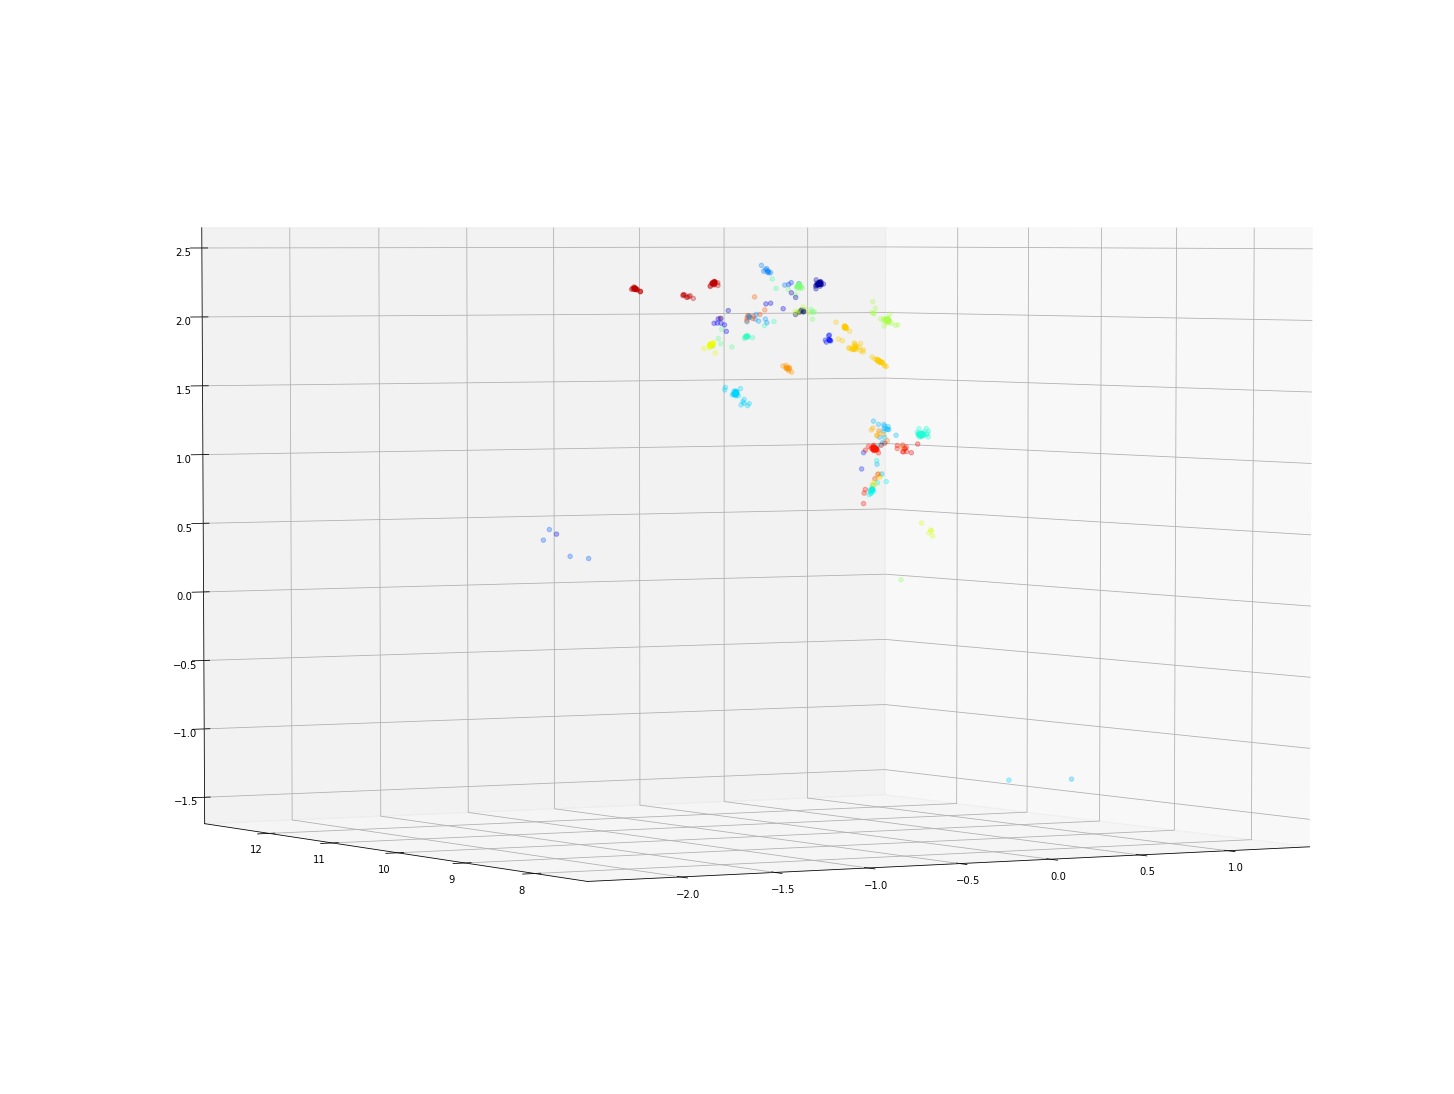

In [8]:
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

fig = plt.figure(figsize=(20, 15))
ax = p3.Axes3D(fig)
ax.view_init(3, -120)
ax.scatter(xyz_filtered[Group_spcm_gteN_idx,0], xyz_filtered[Group_spcm_gteN_idx,1], xyz_filtered[Group_spcm_gteN_idx,2],color=plt.cm.jet(color_map), s=20, alpha=.3)
plt.show()

In [113]:
#df[['Family', 'Genus']].groupby(['Family', 'Genus']).head(1).groupby('Family').size()